In [41]:
import numpy as np
import gzip
import struct
def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [42]:
import matplotlib.pyplot as plt
import random

Training Images Shape: (60000, 28, 28)
Training Labels Shape: (60000,)
Testing Images Shape: (10000, 28, 28)
Testing Labels Shape: (10000,)


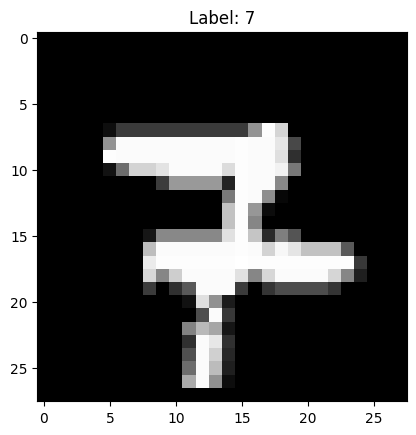

In [43]:
train_images = read_idx('MNIST/train-images-idx3-ubyte.gz')
train_labels = read_idx('MNIST/train-labels-idx1-ubyte.gz')
test_images = read_idx('MNIST/t10k-images-idx3-ubyte.gz')
test_labels = read_idx('MNIST/t10k-labels-idx1-ubyte.gz')

print(f"Training Images Shape: {train_images.shape}")
print(f"Training Labels Shape: {train_labels.shape}")

print(f"Testing Images Shape: {test_images.shape}")
print(f"Testing Labels Shape: {test_labels.shape}")

random_idx = random.randint(0, len(train_images) - 1)

plt.imshow(train_images[random_idx], cmap='gray')
plt.title(f'Label: {train_labels[random_idx]}')
plt.show()

In [44]:
# Normalize pixels to be between 0 and 1
train_images_normalized = train_images.astype(np.float32) / 255.0

print(f"Original pixel value range: [{train_images.min()}, {train_images.max()}]")
print(f"Normalized pixel value range: [{train_images_normalized.min()}, {train_images_normalized.max()}]")


Original pixel value range: [0, 255]
Normalized pixel value range: [0.0, 1.0]


In [45]:
# Use one-hot encoding for labels
train_labels_onehot = np.eye(10)[train_labels]

print(f"Original shape of label: {train_labels.shape}")
print(f"One-hot encoded label shape: {train_labels_onehot.shape}")


Original shape of label: (60000,)
One-hot encoded label shape: (60000, 10)


In [46]:
np.random.seed(695)

# Initialize weights and biases for layers
w1 = np.random.uniform(-0.1, 0.1, (784, 128))
b1 = np.random.uniform(-0.1, 0.1, (128,))

w2 = np.random.uniform(-0.1, 0.1, (128, 64))
b2 = np.random.uniform(-0.1, 0.1, (64,))

w3 = np.random.uniform(-0.1, 0.1, (64, 10))
b3 = np.random.uniform(-0.1, 0.1, (10,))

print(f"W1: {w1.shape}, b1: {b1.shape}")
print(f"W2: {w2.shape}, b2: {b2.shape}")
print(f"W3: {w3.shape}, b3: {b3.shape}")

W1: (784, 128), b1: (128,)
W2: (128, 64), b2: (64,)
W3: (64, 10), b3: (10,)


In [47]:
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))  

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [48]:
# Feed Forward
def feed_forward(x):
    if len(x.shape) > 2:
        x = x.reshape(x.shape[0], -1)
    
    # Hidden layers
    z1 = x @ w1 + b1
    a1 = sigmoid(z1)
    
    z2 = a1 @ w2 + b2
    a2 = sigmoid(z2)
    
    # Output layer
    z3 = a2 @ w3 + b3
    output = softmax(z3)
    
    return output


In [49]:
def categorical_crossentropy(y_true, y_pred):
    n_samples = y_true.shape[0]
    y_pred_clipped = np.clip(y_pred, 1e-12, 1 - 1e-12)
    return -np.sum(y_true * np.log(y_pred_clipped)) / n_samples


In [50]:
def backpropagation(x, y_true):
    n_samples = x.shape[0]
    
    if len(x.shape) > 2:
        x = x.reshape(x.shape[0], -1)
    
    # Layers
    z1 = x @ w1 + b1
    a1 = sigmoid(z1)
    
    z2 = a1 @ w2 + b2
    a2 = sigmoid(z2)
    
    # Output layer
    z3 = a2 @ w3 + b3
    a3 = softmax(z3)
    
    dz3 = (a3 - y_true) / n_samples
    dW3 = a2.T @ dz3
    db3 = np.sum(dz3, axis=0)

    da2 = dz3 @ w3.T
    dz2 = da2 * sigmoid_derivative(z2)
    dW2 = a1.T @ dz2
    db2 = np.sum(dz2, axis=0)
    
    da1 = dz2 @ w2.T
    dz1 = da1 * sigmoid_derivative(z1)
    dW1 = x.T @ dz1
    db1 = np.sum(dz1, axis=0)
    
    return dW1, db1, dW2, db2, dW3, db3


In [51]:
batch_size = 128
epochs = 100
learning_rate = 0.1

X_train = train_images_normalized.reshape(train_images_normalized.shape[0], -1)
y_train = train_labels_onehot

n_samples = X_train.shape[0]
n_batches = n_samples // batch_size

train_losses = []

# Training loop
for epoch in range(epochs):
    indices = np.random.permutation(n_samples)
    X_shuffled = X_train[indices]
    y_shuffled = y_train[indices]
    
    epoch_loss = 0
    
    # Process each mini-batch
    for i in range(n_batches):
        # Get mini-batch
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        X_batch = X_shuffled[start_idx:end_idx]
        y_batch = y_shuffled[start_idx:end_idx]
        
        # Feed forward
        y_pred = feed_forward(X_batch)
        
        batch_loss = categorical_crossentropy(y_batch, y_pred)
        epoch_loss += batch_loss
        
        # Back propagation
        dW1, db1, dW2, db2, dW3, db3 = backpropagation(X_batch, y_batch)
        
        # Update parameters
        w1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        w2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        w3 -= learning_rate * dW3
        b3 -= learning_rate * db3
    
    avg_loss = epoch_loss / n_batches
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

print(f"\nTraining completed!")
print(f"Final loss: {train_losses[-1]:.4f}")


Epoch 10/100, Loss: 0.3149
Epoch 20/100, Loss: 0.2035
Epoch 30/100, Loss: 0.1437
Epoch 40/100, Loss: 0.1101
Epoch 50/100, Loss: 0.0884
Epoch 60/100, Loss: 0.0724
Epoch 70/100, Loss: 0.0603
Epoch 80/100, Loss: 0.0508
Epoch 90/100, Loss: 0.0430
Epoch 100/100, Loss: 0.0367

Training completed!
Final loss: 0.0367


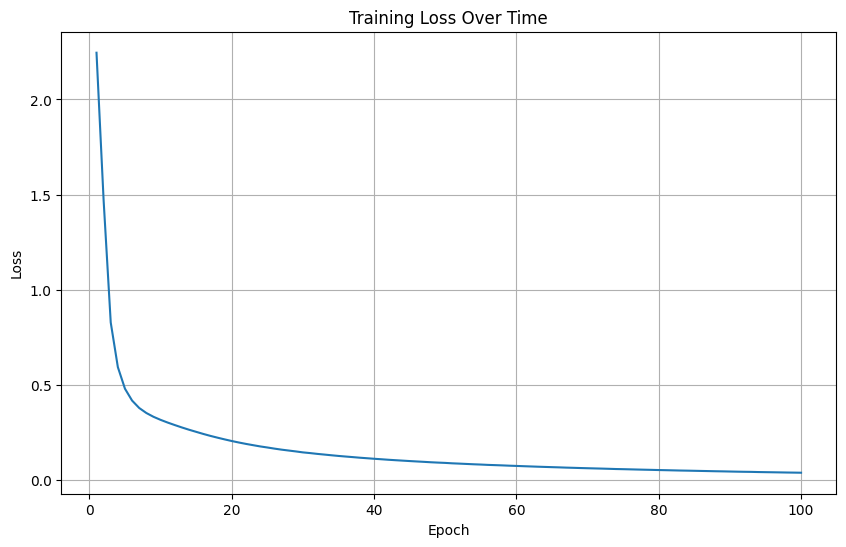

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()


In [53]:
# Test dataset already loaded in Step 1
# Normalize test images
test_images_normalized = test_images.astype(np.float32) / 255.0

X_test = test_images_normalized.reshape(test_images_normalized.shape[0], -1)

predictions = feed_forward(X_test)
predicted_labels = np.argmax(predictions, axis=1)

accuracy = np.mean(predicted_labels == test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Correct predictions: {np.sum(predicted_labels == test_labels)}/{len(test_labels)}")

Test Accuracy: 97.71%
Correct predictions: 9771/10000



Number of misclassified images (Displaying 12): 229


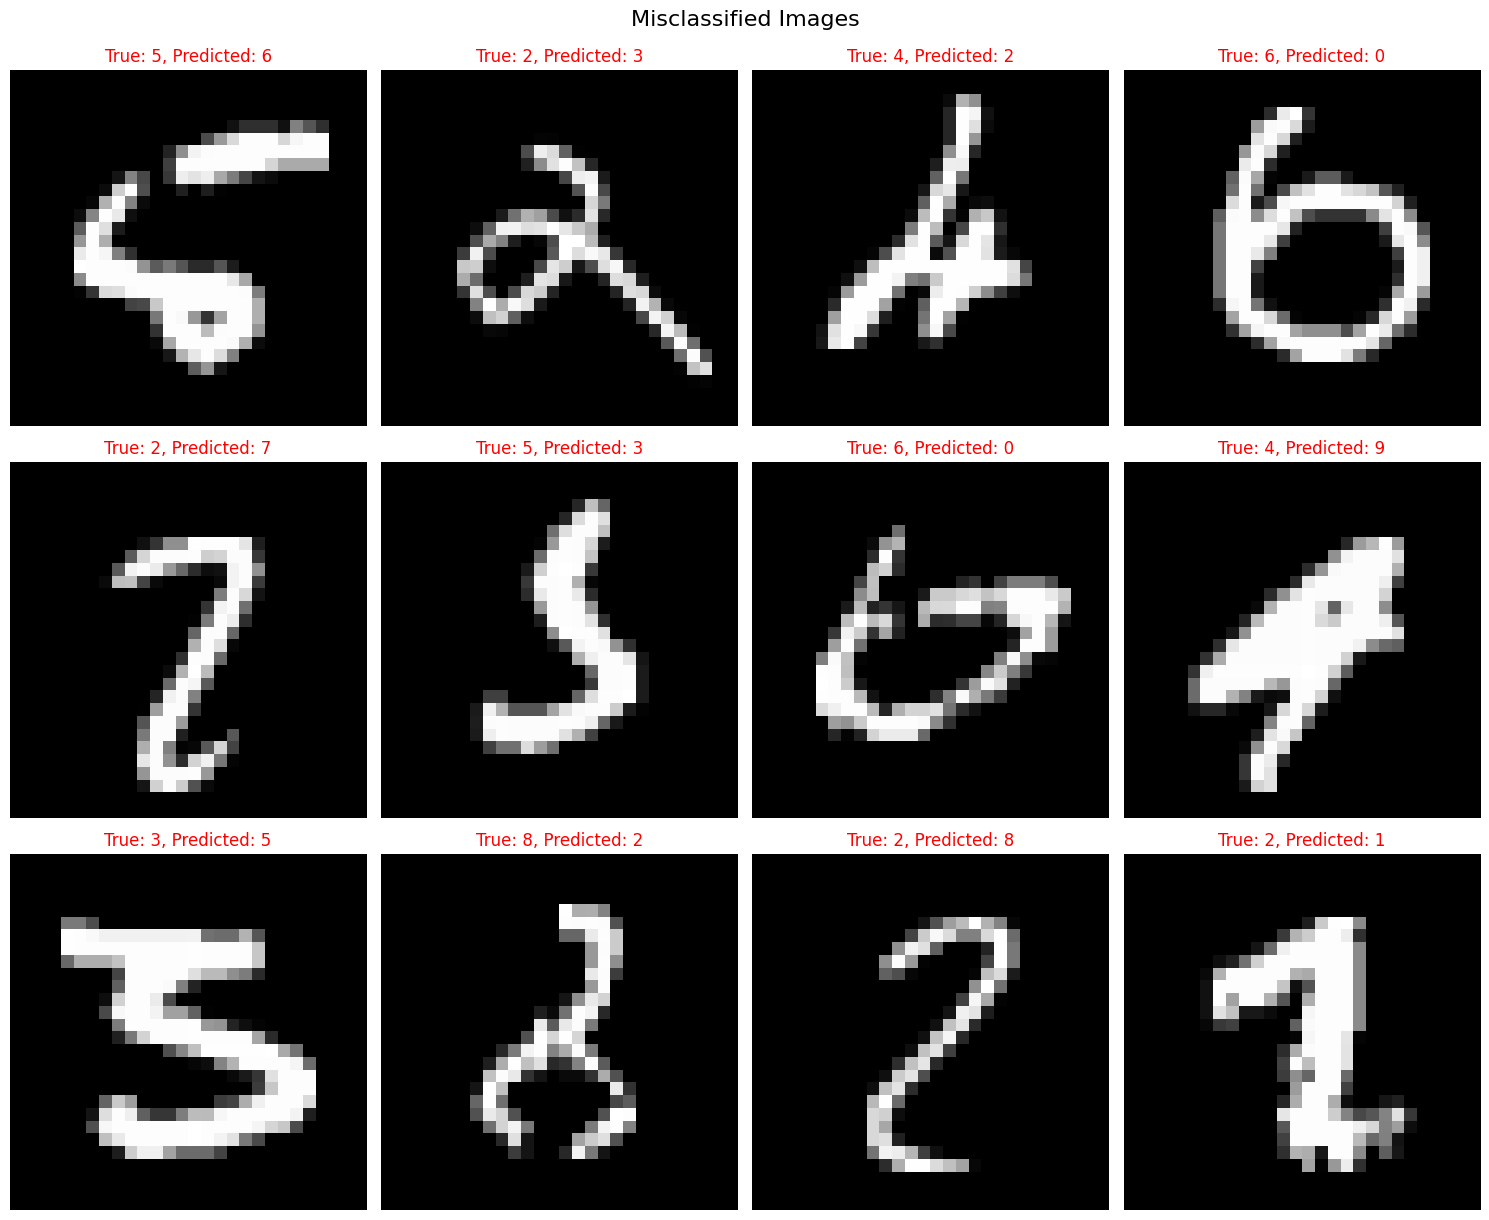

In [54]:
misclassified_indices = np.where(predicted_labels != test_labels)[0]

print(f"\nNumber of misclassified images (Displaying 12): {len(misclassified_indices)}")

n_plot = min(12, len(misclassified_indices))
selected_indices = misclassified_indices[:n_plot]

n_cols = 4
n_rows = (n_plot + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten() if n_plot > 1 else [axes]

for idx, ax in enumerate(axes):
    if idx < n_plot:
        img_idx = selected_indices[idx]
        ax.imshow(test_images[img_idx], cmap='gray')
        ax.set_title(f'True: {test_labels[img_idx]}, Predicted: {predicted_labels[img_idx]}', 
                     fontsize=12, color='red' if test_labels[img_idx] != predicted_labels[img_idx] else 'black')
        ax.axis('off')

plt.tight_layout()
plt.suptitle('Misclassified Images', fontsize=16, y=1.02)
plt.show()
